# Code for scraping 
Need not run this code as the scraping is done already

Install Selenium and Chromium driver for scraping the data

In [ ]:
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 KB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 6.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubunt

Import the necessary libraries

In [ ]:
import threading
import json
from bs4 import BeautifulSoup
from selenium import webdriver
import time
from selenium.common.exceptions import NoSuchElementException
import pandas as pd
import sys

Rendering the web page content

In [ ]:
def rendering(driver, url, index=None, result=None):  
  driver.get(url)                                          # load the web page from the URL
  time.sleep(3)                                            # wait for the web page to load
  render = driver.page_source                              # get the page source HTML
  if index != None:
        result[index] = render
        return

  return render

Open Chromium and parse the rendered html content

In [ ]:
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
chrome_options = webdriver.chrome.options.Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

#each url corresponds to different years
urls = ['https://ieeexplore.ieee.org/xpl/tocresult.jsp?isnumber=9668973&punumber=6287639','https://ieeexplore.ieee.org/xpl/tocresult.jsp?isnumber=9312710&punumber=6287639','https://ieeexplore.ieee.org/xpl/tocresult.jsp?isnumber=8948470&punumber=6287639','https://ieeexplore.ieee.org/xpl/tocresult.jsp?isnumber=8600701&punumber=6287639']


#only the title, link, year of publication, authors and citations are scraped
data = [None]*4
data[0] = pd.DataFrame(columns=['title','link','year','authors','citations'])
data[1] = pd.DataFrame(columns=['title','link','year','authors','citations'])
data[2] = pd.DataFrame(columns=['title','link','year','authors','citations'])
data[3] = pd.DataFrame(columns=['title','link','year','authors','citations'])

def extract(url, ind):
  counter = 0
  driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
  driver.get(url)
  time.sleep(5)
  while True:
    render = driver.page_source

    soup = BeautifulSoup(render, 'html.parser')
    soup = soup.find_all('div', attrs={'class': 'col result-item-align'})

    for i in soup:
      try:
        d = dict()
        title = i.find('h2').find('a', href=True)
        d['title'] = title.text.strip()
        d['link'] = title['href']

        authors = i.find('p', attrs={'class': 'author text-base-md-lh'}).find_all('span', attrs={'class': 'text-base-md-lh'})
        author_list = []
        for author in authors:
          author_list.append(author.find('a').find('span').text.strip())
        d['authors'] = author_list

        description = i.find('div', attrs={'class': 'description text-base-md-lh'}).find_all('div')
        d['year'] = int(description[0].find('span').text.strip().split(' ')[2])
      except:
        continue

      try:
        d['citations'] = int(description[1].find('span').find('a').text.strip().split(' ')[1][1:-1])
      except IndexError:
        d['citations'] = 0

      data[ind] = data[ind].append(d, ignore_index=True)
      counter += 1
    print(ind, end=' ')
    print(counter)

    if counter >= 500:
      break
    
    try:
      l = driver.find_element("link text",">")
      driver.execute_script("arguments[0].click();", l)
      time.sleep(5)
    except NoSuchElementException:
      break
  driver.quit()



Using Threads to parallely scrape the data

In [ ]:
#using 4 threads where each thread scraps data from four different years
threads = [None]*4
threads[0] = threading.Thread(target=extract, args=(urls[0], 0))
threads[0].start()
threads[1] = threading.Thread(target=extract, args=(urls[1], 1))
threads[1].start()
threads[2] = threading.Thread(target=extract, args=(urls[2], 2))
threads[2].start()
threads[3] = threading.Thread(target=extract, args=(urls[3], 3))
threads[3].start()
for i in range(4):
  threads[i].join()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: use options instead of chrome_options
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: use options instead of chrome_options
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: use options instead of chrome_options


2 25
1 25
0 25
3 25
2 50
1 50
0 50
3 50
2 75
0 75
1 75
3 75


Exception in thread Thread-17:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connection.py", line 175, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/usr/local/lib/python3.7/dist-packages/urllib3/util/connection.py", line 95, in create_connection
    raise err
  File "/usr/local/lib/python3.7/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py", line 710, in urlopen
    chunked=chunked,
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connection.py", line 239, in request
    super(HT

2 100
0 100


Exception in thread Thread-15:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connection.py", line 175, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/usr/local/lib/python3.7/dist-packages/urllib3/util/connection.py", line 95, in create_connection
    raise err
  File "/usr/local/lib/python3.7/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py", line 710, in urlopen
    chunked=chunked,
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py", line 398, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/usr/local/lib/python3.7/dist-packages/urllib3/connection.py", line 239, in request
    super(HT

1 100


KeyboardInterrupt: ignored

Scrape the abstract using the research paper link scraped previously

In [ ]:
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

abstract = []
for i in range(300):
  driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
  url = "https://ieeexplore.ieee.org" + data.iloc[i]['link']
  driver.get(url)
  time.sleep(3)
  render = driver.page_source
  driver.quit()
  soup = BeautifulSoup(render, 'html.parser')
  try:
    txt = soup.find_all('div', attrs={'class': 'u-mb-1'})[1].find('div').text.strip()
    abstract.append(txt)
  except:
    abstract.append('')
  print(i)


# Preprocessing

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
import pandas as pd
import time

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Normalize the text by converting to lower case, by removing punctuation, by lematization

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
stop = stopwords.words('english')
lem = WordNetLemmatizer()

def stop_lemmatize(doc):
    tokens = nltk.word_tokenize(doc)
    tmp = ""
    for w in tokens:
        if w not in stop:
            tmp += lem.lemmatize(w, get_wordnet_pos(w)) + " "
    return tmp

In [ ]:
def transform_df(df):
  df['title'] = df['title'].apply(process_string)
  df['abstract'] = df['abstract'].apply(process_string)
  return df

Creating Index also called as Posting List

In [ ]:
def index_it(entry, index):
  words = str(entry['title']).split()
  words.extend(str(entry['abstract']).split())
  ID = entry.Id
  for word in words:
    if word in index.keys():
      if ID not in index[word]:
        index[word].append(ID)
    else:
      index[word] = [ID]
  return index

In [ ]:
def index_all(df, index):
  for i in range(len(df)):
    entry = df.loc[i,:]
    index = index_it(entry = entry, index = index)
  return index

In [ ]:
def build_index(df, index):
    #to_add = transform_df(df)
    index = index_all(df, index = index)
    return index

In [ ]:
database = pd.read_csv('database.csv')
database = database.drop(['Unnamed: 0'], axis=1)
data = database.copy()

In [ ]:
data

,Id,title,link,year,authors,citations,abstract
0,0,Bargaining Game Based Time Scheduling Scheme f...,/document/9615057/,2021,['Sungwook Kim'],0,Backscatter communications have been acknowled...
1,1,The Use of Tangible User Interfaces in K12 Edu...,/document/9721879/,2022,"['José A. Gallud', 'Ricardo Tesoriero', 'Maria...",0,Tangible User Interfaces have enriched and exp...
2,2,Transient Surface Charge Characteristics of DC...,/document/9714376/,2022,"['Xiaolong Li', 'Songling Han', 'Mingde Wan', ...",0,The insulator in direct current gas-insulated ...
3,3,Electromagnetic Vibration Characteristics Anal...,/document/8918234/,2019,"['Defeng Kong', 'Zhijun Shuai', 'Wanyou Li', '...",3,Electromagnetic vibration is an important exci...
4,4,kNN-STUFF: kNN STreaming Unit for Fpgas,/document/8911384/,2019,"['João Vieira', 'Rui P. Duarte', 'Horácio C. N...",11,This paper presents kNN STreaming Unit For Fpg...
...,...,...,...,...,...,...,...
596,596,Design of 94GHz Dual-Polarization Antenna Fed ...,/document/9721223/,2022,"['Jie Wang', 'Hai Lin', 'Fan Yang', 'Guangyang...",0,"In this paper, a 94 GHz dual-polarization high..."
597,597,Memory Storage Systems Utilizing Chaotic Attra...,/document/9703364/,2022,"['Sou Nobukawa', 'Nobuhiko Wagatsuma', 'Haruhi...",0,In nonlinear dynamical systems with barriers/t...
598,598,NADS-RA: Network Anomaly Detection Scheme Base...,/document/9269968/,2020,"['Xu Liu', 'Xiaoqiang Di', 'Qiang Ding', 'Weiy...",3,Network anomaly detection aims to identify net...
599,599,Quality Aware Features for Performance Predict...,/document/9698081/,2022,"['Roger Gomez-Nieto', 'José Franciso Ruiz-Muño...",0,The existing body of work on video object trac...


Posting list created

In [ ]:
idx = build_index(data, index = {})

In [ ]:
idx

{'Bargaining': [0, 417],
 'Game': [0],
 'Based': [0,
  15,
  17,
  21,
  23,
  29,
  36,
  48,
  49,
  63,
  71,
  73,
  76,
  78,
  85,
  86,
  93,
  94,
  96,
  111,
  113,
  120,
  122,
  123,
  124,
  125,
  128,
  134,
  138,
  147,
  149,
  150,
  154,
  156,
  157,
  163,
  168,
  170,
  175,
  187,
  190,
  197,
  203,
  207,
  209,
  212,
  219,
  220,
  226,
  230,
  231,
  242,
  249,
  259,
  270,
  292,
  298,
  299,
  310,
  318,
  322,
  326,
  327,
  328,
  330,
  335,
  341,
  343,
  348,
  351,
  353,
  357,
  359,
  367,
  375,
  377,
  379,
  381,
  383,
  387,
  390,
  394,
  395,
  396,
  401,
  403,
  404,
  405,
  409,
  413,
  415,
  417,
  422,
  423,
  434,
  439,
  442,
  451,
  459,
  467,
  475,
  478,
  481,
  496,
  508,
  514,
  520,
  522,
  531,
  533,
  535,
  545,
  549,
  556,
  566,
  572,
  578,
  579,
  585,
  588,
  598],
 'Time': [0, 90, 161, 206, 273, 299, 434, 446, 472, 599],
 'Scheduling': [0, 5, 6, 48, 169, 286, 348, 472, 512, 562],
 'Sche

Preprocessed documents

In [ ]:
data

,Id,title,link,year,authors,citations,abstract
0,0,Bargaining Game Based Time Scheduling Scheme f...,/document/9615057/,2021,['Sungwook Kim'],0,Backscatter communications have been acknowled...
1,1,The Use of Tangible User Interfaces in K12 Edu...,/document/9721879/,2022,"['José A. Gallud', 'Ricardo Tesoriero', 'Maria...",0,Tangible User Interfaces have enriched and exp...
2,2,Transient Surface Charge Characteristics of DC...,/document/9714376/,2022,"['Xiaolong Li', 'Songling Han', 'Mingde Wan', ...",0,The insulator in direct current gas-insulated ...
3,3,Electromagnetic Vibration Characteristics Anal...,/document/8918234/,2019,"['Defeng Kong', 'Zhijun Shuai', 'Wanyou Li', '...",3,Electromagnetic vibration is an important exci...
4,4,kNN-STUFF: kNN STreaming Unit for Fpgas,/document/8911384/,2019,"['João Vieira', 'Rui P. Duarte', 'Horácio C. N...",11,This paper presents kNN STreaming Unit For Fpg...
...,...,...,...,...,...,...,...
596,596,Design of 94GHz Dual-Polarization Antenna Fed ...,/document/9721223/,2022,"['Jie Wang', 'Hai Lin', 'Fan Yang', 'Guangyang...",0,"In this paper, a 94 GHz dual-polarization high..."
597,597,Memory Storage Systems Utilizing Chaotic Attra...,/document/9703364/,2022,"['Sou Nobukawa', 'Nobuhiko Wagatsuma', 'Haruhi...",0,In nonlinear dynamical systems with barriers/t...
598,598,NADS-RA: Network Anomaly Detection Scheme Base...,/document/9269968/,2020,"['Xu Liu', 'Xiaoqiang Di', 'Qiang Ding', 'Weiy...",3,Network anomaly detection aims to identify net...
599,599,Quality Aware Features for Performance Predict...,/document/9698081/,2022,"['Roger Gomez-Nieto', 'José Franciso Ruiz-Muño...",0,The existing body of work on video object trac...


In [ ]:
print(len(idx)) #Vocabulary size

17968


# Boolean Model

Split the query into list of terms

In [ ]:
def process_query(query):
    norm = process_string(query)
    return norm.split()

Performing Boolean AND by SET Intersection operation

In [ ]:
def lists_intersection(lists):
    intersect = list(set.intersection(*map(set, lists)))
    intersect.sort()
    return intersect

Get the details of retrieved document Id's

In [ ]:
def connect_id_df(retrieved_id, df):
    return df[df.Id.isin(retrieved_id)].reset_index(drop=True)

Search for the posting list of terms present in the query

In [ ]:
def search_postlist(query, index=idx):
    #query_split = process_query(query)
    query_split = query.split()
    retrieved = []
    for word in query_split:
        if word in index.keys():
            retrieved.append(index[word])
    if len(retrieved) > 0:
        result = lists_intersection(retrieved)
    else:
        result = [0]
    result = connect_id_df(result, database)
    return result

In [ ]:
def search(query):
    start = time.time()
    result = search_postlist(query)
    print("results:")
    for i in range(len(result)):
      print(result.iloc[i].Id, end="  ")
      print(result.iloc[i].title)


In [ ]:
def search_doc():
    query = str(input("Search for: "))
    search(query=query)

In [ ]:
search_doc()

Search for: machine learning
results:
12  Advances in Adversarial Attacks and Defenses in Computer Vision: A Survey
34  Sentiment Analysis of Customers’ Reviews Using a Hybrid Evolutionary SVM-Based Approach in an Imbalanced Data Distribution
44  Neural Network Approach to Program Synthesis for Tabular Transformation by Example
82  Differential Privacy Preservation in Robust Continual Learning
104  Two-Dimensional RSSI-Based Indoor Localization Using Multiple Leaky Coaxial Cables With a Probabilistic Neural Network
107  Machine Learning and Deep Learning Approaches for CyberSecurity: A Review
110  Wind Speed Prediction Using Hybrid 1D CNN and BLSTM Network
114  Investigating Frontal Neurovascular Coupling in Response to Workplace Design-Related Stress
124  Exponential Loss Minimization for Learning Weighted Naive Bayes Classifiers
149  Robust Network Intrusion Detection System Based on Machine-Learning With Early Classification
155  A Hybrid Deep Learning Approach for Replay and DDoS A

# Vector Space Model

In [ ]:
vectorspace_dataset = [str(data.loc[i].title) + str(data.loc[i].abstract) for i in range(len(data))]

In [ ]:
vectorspace_dataset

['Bargaining Game Based Time Scheduling Scheme for Ambient Backscatter CommunicationsBackscatter communications have been acknowledged as an essential key technology in the Internet of Things (IoT) applications. Considering the fact that it needs the coordination from network agents, cooperative bargaining theory is an effective method to strike an appropriate system performance. In this paper, we investigate time scheduling algorithms for a backscatter-aided radio-frequency (RF) powered cognitive radio (CR) network, where multiple secondary transmitters can switch among the backscatter, the energy harvest, and active data transmission modes. Our objective is to maximize the RF-CR system performance while exploring the mutual benefits to leverage a reciprocal consensus between different control issues. According to the ideas of two different bargaining solutions - \nmodified Nash bargaining solution\n and \nequitable Nash bargaining solution\n, we design a new dual bargaining game mode

Calculate the tf-idf weights

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
docs_tfidf = vectorizer.fit_transform(vectorspace_dataset)

def get_tf_idf_query_similarity(vectorizer, docs_tfidf, query):
    """
    vectorizer: TfIdfVectorizer model
    docs_tfidf: tfidf vectors for all docs
    query: query doc

    return: cosine similarity between query and all docs
    """
    query_tfidf = vectorizer.transform([query])
    cosineSimilarities = cosine_similarity(query_tfidf, docs_tfidf).flatten()
    return cosineSimilarities

In [ ]:
#cosine similarity of all the documents with respect to the query
ans = get_tf_idf_query_similarity(vectorizer, docs_tfidf, "machine learning")

In [ ]:
ans

array([0.        , 0.02027404, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.13500505, 0.02109978, 0.08423065,
       0.        , 0.05752044, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.10650656, 0.0803472 , 0.        , 0.        , 0.09043045,
       0.        , 0.        , 0.        , 0.        , 0.07981626,
       0.        , 0.        , 0.        , 0.03237612, 0.0339248 ,
       0.04217732, 0.        , 0.03254006, 0.11904672, 0.        ,
       0.10953423, 0.        , 0.02953849, 0.        , 0.        ,
       0.        , 0.        , 0.01406433, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02053643, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.05887

In [ ]:
max_citations = max(data.citations)
max_year = max(data.year)

Calculate final relevance score based on the Cosine Similarity, Published year and the Number of Citations.


a denotes weightage or importance to be given to the year of publication.


b denotes weightage or importance to be given to the number of citations.


c denotes weightage or importance to be given to the cosine similarity.

In [ ]:
a = 0.15
b = 0.15
c = 0.7
#note that a+b+c must be equal to 1

Computing the final scores of documents. Here Year and Citations are normalized.

In [ ]:
score = [a*(data.loc[i].year/max_year) + b*(data.loc[i].citations/max_citations) + c*(ans[i]) for i in range(len(data))]
score=list(enumerate(score))

In [ ]:
score.sort(key=lambda x:x[1],reverse=True)

In [ ]:
k = 10 #Number of documents to be retireved
score = score[:k]

Results

In [ ]:
rel=[]
for i in score:
  print(database.iloc[i[0]].Id, end="  ")
  print(database.iloc[i[0]].title)

107  Machine Learning and Deep Learning Approaches for CyberSecurity: A Review
446  Clustering and Classification for Time Series Data in Visual Analytics: A Survey
371  Subjective Answers Evaluation Using Machine Learning and Natural Language Processing
560  Security and Privacy for the Internet of Medical Things Enabled Healthcare Systems: A Survey
19  Vehicle-to-Grid Aggregator to Support Power Grid and Reduce Electric Vehicle Charging Cost
267  SEQ2SEQ++: A Multitasking-Based Seq2seq Model to Generate Meaningful and Relevant Answers
433  Analysis of Data Management in Blockchain-Based Systems: From Architecture to Governance
226  LinRegDroid: Detection of Android Malware Using Multiple Linear Regression Models-Based Classifiers
469  An Efficient Hardware Implementation of Reinforcement Learning: The Q-Learning Algorithm
538  Mobile Apps Meet the Smart Energy Grid: A Survey on Consumer Engagement and Machine Learning Applications


Accuracy Measure

In [ ]:
rel=[]
nrel=[]
for i in range(0,len(ans)):
  if ans[i]>0:
    rel.append(i)
  else:
    nrel.append(i)
rel

[1,
 12,
 13,
 14,
 16,
 30,
 31,
 34,
 39,
 43,
 44,
 45,
 47,
 48,
 50,
 52,
 57,
 67,
 74,
 78,
 82,
 85,
 93,
 103,
 104,
 107,
 110,
 114,
 116,
 124,
 127,
 128,
 129,
 133,
 134,
 140,
 143,
 147,
 149,
 152,
 155,
 156,
 158,
 161,
 163,
 164,
 167,
 171,
 183,
 186,
 188,
 189,
 192,
 196,
 201,
 202,
 207,
 213,
 214,
 221,
 225,
 226,
 229,
 231,
 236,
 238,
 245,
 248,
 249,
 256,
 259,
 266,
 267,
 270,
 278,
 281,
 282,
 286,
 295,
 301,
 309,
 310,
 314,
 320,
 327,
 336,
 338,
 339,
 344,
 346,
 359,
 361,
 363,
 364,
 368,
 369,
 371,
 373,
 376,
 383,
 387,
 391,
 399,
 408,
 413,
 416,
 419,
 420,
 424,
 426,
 429,
 438,
 440,
 446,
 450,
 452,
 461,
 466,
 469,
 471,
 473,
 474,
 476,
 477,
 478,
 479,
 484,
 500,
 507,
 508,
 523,
 524,
 538,
 543,
 544,
 552,
 558,
 562,
 565,
 566,
 567,
 569,
 573,
 575,
 577,
 585,
 590,
 593]

In [ ]:
precision=[0 for i in range(len(data))]
recall=[0 for i in range(len(data))]
rc=0
totrel=len(rel)
for i in range(0,len(data)):
  if i in rel:
    rc+=1
    precision[i]=rc/(i+1)
    recall[i]=rc/totrel
print(precision)
print(recall)

[0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.15384615384615385, 0.21428571428571427, 0.26666666666666666, 0, 0.29411764705882354, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1935483870967742, 0.21875, 0, 0, 0.22857142857142856, 0, 0, 0, 0, 0.225, 0, 0, 0, 0.22727272727272727, 0.24444444444444444, 0.2608695652173913, 0, 0.2708333333333333, 0.2857142857142857, 0, 0.29411764705882354, 0, 0.3018867924528302, 0, 0, 0, 0, 0.29310344827586204, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2647058823529412, 0, 0, 0, 0, 0, 0, 0.25333333333333335, 0, 0, 0, 0.25316455696202533, 0, 0, 0, 0.25301204819277107, 0, 0, 0.2558139534883721, 0, 0, 0, 0, 0, 0, 0, 0.24468085106382978, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.23076923076923078, 0.23809523809523808, 0, 0, 0.24074074074074073, 0, 0, 0.24324324324324326, 0, 0, 0, 0.24347826086956523, 0, 0.24786324786324787, 0, 0, 0, 0, 0, 0, 0, 0.24, 0, 0, 0.2421875, 0.24806201550387597, 0.25384615384615383, 0, 0, 0, 0.2537313432835821, 0.25925925925925924, 0, 0, 0, 0, 0, 0.2553191489361702, 0, 0

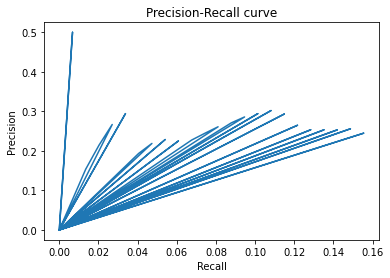

In [ ]:
import matplotlib.pyplot as plt
  
# x axis values
x = [recall[i] for i in range(0,100)]
# corresponding y axis values
y = [precision[i] for i in range(0,100)]
  
# plotting the points 
plt.plot(x, y)
  
# naming the x axis
plt.xlabel('Recall')
# naming the y axis
plt.ylabel('Precision')
  
# giving a title to my graph
plt.title('Precision-Recall curve')
  
# function to show the plot
plt.show()

# Probabilistic Model - Multinomial Classification

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd

# Load data into a DataFrame
database = pd.read_csv('database.csv')

# Create a TF-IDF vectorizer and fit it to the corpus
vectorizer = TfidfVectorizer()
tfidf_mat = vectorizer.fit_transform(database['abstract'].values.astype('U'))

# Fit a Naive Bayes model to the transformed data
nb = MultinomialNB()
nb.fit(tfidf_mat, database['title'])

# Define a function to retrieve papers related to a given topic
def retrieve_papers(topic):
    # Transform the query topic using the vectorizer
    topic_mat = vectorizer.transform([topic])

    # Use the Naive Bayes model to predict the relevance of each paper in the database
    relevance_scores = nb.predict_proba(topic_mat.multiply(tfidf_mat))

    # Return the top 10 most relevant papers as a DataFrame
    return database.iloc[relevance_scores.argsort()[0][-10:]]

# Example usage
topic = "game theory"
results = retrieve_papers(topic)
print(results)

     Unnamed: 0   Id                                              title  \
443         443  443  Medium Voltage Large-Scale Grid-Connected Phot...   
273         273  273  Proof of Pseudonym: Blockchain-Based Privacy P...   
257         257  257  Depression Prevalence in Postgraduate Students...   
248         248  248  Robust Deep Learning-Based Driver Distraction ...   
174         174  174  Pollution Flashover Voltage of Transmission Li...   
42           42   42  Robot-Assisted Joint Attention: A Comparative ...   
430         430  430  Dispatch for Urban Integrated Heat and Power S...   
157         157  157            Pattern Matching Based on Object Graphs   
516         516  516  Flexible Pricing Strategies in Electric Free-F...   
231         231  231  Ensemble Feature Ranking for Cost-Based Non-Ov...   

                   link  year  \
443  /document/9294009/  2020   
273  /document/9638655/  2021   
257  /document/8918399/  2019   
248  /document/9641850/  2021   
174  /doc

# Latent Semantic Analysis and Clustering

Using LSA, a low-rank approximation of the original matrix can be created (with some loss of information although!) that can be used for our clustering purpose.

In [ ]:
#Here documents are reduced to dimension of 200
tsvd = TruncatedSVD(n_components=200)
tsvd.fit(docs_tfidf)
tsvd_mat = tsvd.transform(docs_tfidf)

100%|██████████| 19/19 [00:59<00:00,  3.12s/it]


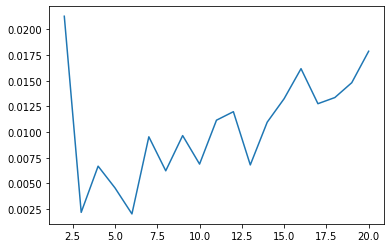

In [ ]:
s_list = []
for clus in tqdm(range(2,21)):

    km = KMeans(n_clusters=clus, n_init=50, max_iter=1000) # Instantiate KMeans clustering

    km.fit(tsvd_mat) # Run KMeans clustering

    s = silhouette_score(tsvd_mat, km.labels_)

    s_list.append(s)
plt.plot(range(2,21), s_list)

plt.show()

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

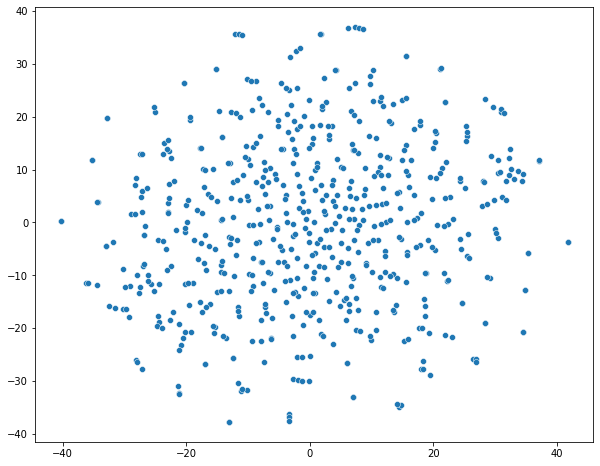

In [ ]:
tsne = TSNE(n_components=2) # T Distributed Stochastic Neighbour Embedding
tsne_mat = tsne.fit_transform(tsvd_mat)
plt.figure(figsize=(10,8))
sns.scatterplot(tsne_mat[:,0],tsne_mat[:,1])

In [ ]:
from sklearn.metrics import pairwise_distances
import numpy as np
query = "game theory"
query_mat = tsvd.transform(vectorizer.transform([query]))
dist = pairwise_distances(X=tsvd_mat, Y=query_mat, metric='euclidean')
database.loc[np.argmin(dist.flatten())]

Id                                                         245
title        Development of Serious Games for Teaching Info...
link                                        /document/8911357/
year                                                      2019
authors             ['Mahmoud Mostafa', 'Osama S. Faragallah']
citations                                                    5
abstract     Serious games have been used effectively in ma...
Name: 245, dtype: object